# <p style="text-align:center">Lecture 4. E-Cell4における空間</p>

<p style="text-align:center;font-size:150%;line-height:150%">海津一成</p>

In [2]:
%matplotlib inline
from ecell4 import *

In [3]:
import seaborn
seaborn.set(font_scale=1.5)

## E-Cell4における空間

前回はE-Cell4における3つの要素`Model`、`World`、`Simulator`について説明した。また、常微分方程式ソルバである`ode`と確率論的手法である`gillespie`を用いて簡単な計算を試した。

`ode`や`gillespie`で計算を行なう際には容積を与えて`World`を作成したがE-Cell4における空間の取り扱いはどのようなものだろうか？

In [4]:
w1 = ode.ODEWorld(Real3(1, 1, 1))
w2 = gillespie.GillespieWorld(Real3(1, 1, 1))

`ode`と`gillespie`では上の例のように一辺が1の立方体の中で計算を行ったが実際にはその容積しか問題ではない。つまり、

In [6]:
w3 = ode.ODEWorld(Real3(2, 0.5, 1))  # is almost equivalent to 'w1'
w4 = gillespie.GillespieWorld(Real3(2, 2, 0.25))  # is almost equivalent to 'w2'

としても結局容積として1を与えるので同じ計算結果を示すだろう。

これは実際試験管内のように十分に攪拌され、空間的に均一な系では妥当に思える。

しかしながら、細胞内は明かに空間的に一様とは言えない。こうした分子の局在を考慮するためには空間を考慮した生化学計算が必要である。

E-Cell4では様々な空間表現やそれに対応した計算技法が利用可能である。

以下ではまずその内の1つである空間Gillespie法を例にE-Cell4における空間の取り扱いについて見ていく。

## 空間Gillespie法

E-Cell4で空間Gillespie法は`meso`モジュールに含まれている。まずは何も考えずに初級編で見たように`run_simulation`を用いて計算してみよう。

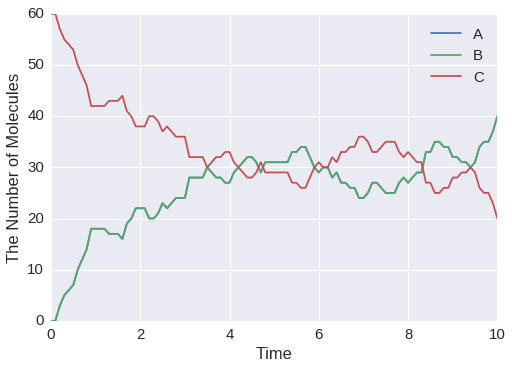

In [7]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

y = run_simulation(10, {'C': 60}, solver='meso')

`ode`や`gillespie`に比べて幾分時間がかかったかもしれないがほぼ同じ結果が得られるだろう。`meso`モジュールは空間の設定を加えなければ`gillespie`とほとんど等価な計算を行う。

`run_simulation`を展開してみると、

In [8]:
with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

In [10]:
w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(1, 1, 1))  # XXX: Point3
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.MesoscopicSimulator(w)  # XXX: Point2
sim.run(10)

使うものが`MesoscopicWorld`、`MesoscopicSimulator`になった以外はほとんど同じであるが、いくつか新しい要素がある。

1. まず、'w.bind_to(m)'ではWorldにModelを関連付けている。前回はこれをせずに済ませたが、空間的技法では`Species`の属性が非常に重要となるので忘れないようにしよう。
1. その代わりに`MesoscopicSimulator`には`World`だけを与えれば十分である。
1. 次に重要な違いとして`MesoscopicWorld`を作る際に、2つ目の引数として`Integer3(1, 1, 1)`を与えている。

最後の点は`ODEWorld`や`GillespieWorld`ではみられなかったものだ。これが何かを説明する前にとりあえず変更してどうなるか試してみよう。

In [12]:
w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(4, 4, 4))  # <- Integer3(1, 1, 1)

（中略）

In [13]:
w.bind_to(m)
w.add_molecules(Species('C'), 60)

sim = meso.MesoscopicSimulator(w)
obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10, obs)

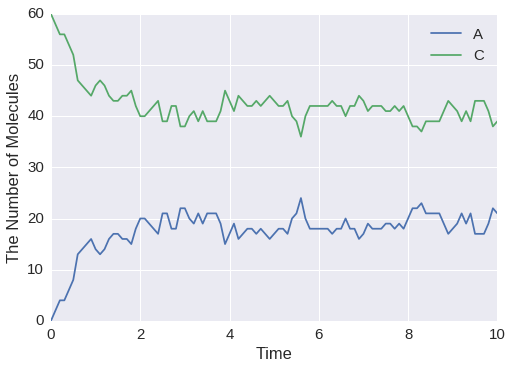

In [14]:
viz.plot_number_observer(obs)

先程や`ode`、`gillespie`などとは違う結果が得られた。数字を大きくすれば結果の違いもより顕著になる。

実はこの2つ目の引数は空間の分割数を表している。

`meso`は`gillespie`とほぼ同じであるが、`gillespie`が1つの均一な閉じた空間の中で計算を行っているのに対して、`meso`は空間をSubvolumeと呼ばれる小さな直方体に分割し、それぞれのSubvolumeが異なる分子濃度を持つことを許す。

従って先程の`Integer3(4, 4, 4)`を用いた例では、一辺が1の立方体を一辺が0.25の立方体64個に分割する。

<center><img src="images/Figure4-1.png" width="60%"></center>

最初に分子種Cを60個投入しているから, 1つのSubvolume当り高々1個程度のCが含まれることになる. このとき, Cの濃度は最初の場合と同じだが, かい離した後のAの濃度が異なる. かい離したばかりの1つのA分子の濃度は, 元々は1/1=11/1=1であったが, Subvolumeでは1/(1/64)=641/(1/64)=64となってしまう. 実際にはこの程度の分割数であればここまでの効果は出ないが, 結果とて結合する反応が速くなるため, 上のように結合状態Cの量が多くなる. 別の見方で説明しよう. mesoではかい離直後のAとBは必ず同じSubvolume内にいる. 一方, gillespieでは十分に攪拌された均一な系を仮定しているので, かい離直後のAとB分子は64つのSubvolumeのいずれかに含まれることになる. このときAとBが同じSubvolumeに含まれる確率は1/641/64である. 従ってやはり結合する確率が高くなる.